# ЛР №1. Data Storytelling

Выполнил: Кривцов Н.А, студент группы ИУ5-22М

## Задание

1. Выбрать набор данных.
2. Создать "историю о данных".
3. Сформировать отчет и разместить в репозитории Github.

## Требования к истории данных

1. История должна содержать не менее 5 шагов (где 5 - рекомендуемое количество шагов). Каждый шаг содержит график и его текстовую интерпретацию.
2. На каждом шаге наряду с удачным итоговым графиком рекомендуется в юпитер-ноутбуке оставлять результаты предварительных "неудачных" графиков.
3. Не рекомендуется повторять виды графиков, желательно создать 5 графиков различных видов.
4. Выбор графиков должен быть обоснован использованием методологии data-to-viz. Рекомендуется учитывать типичные ошибки построения выбранного вида графика по методологии data-to-viz. Если методология Вами отвергается, то прешение по выбору графика должно быть обосновано.
5. История должна содержать итоговые выводы. 

# Выполнение работы


## Импорт библиотек и загрузка датасета



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
fpath = '/content/drive/MyDrive/ММО/games.csv'

df = pd.read_csv(fpath)
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [3]:
df.drop(labels=['id', 'created_at', 'last_move_at', 'white_id', 'black_id', 'opening_eco', 'moves'], axis=1, inplace=True)

In [4]:
# sns.set_theme(style='darkgrid')

In [5]:
df = df[(df.turns <= 200) & (df.rated)]

In [6]:
# функции для генерации вспомогательных колонок

def get_opening_family(row):
  family_name = row['opening_name'].partition(':')[0].partition('#')[0].partition('|')[0].rstrip(' ')
  if family_name[-4:] == 'Pawn':
    return family_name + ' Game'
  else:
    return family_name

def get_game_rating(row):
  return (row['white_rating'] + row['black_rating']) // 2

def get_rating_diff(row):
  return (row['white_rating'] - row['black_rating'])

def get_rating_group(row):
  rating = row['game_rating']
  if rating < 1000:
    return 'U1000'
  if rating < 1500:
    return 'U1500'
  if rating < 2000:
    return 'U2000'
  else:
    return 'U3000'

In [7]:
# генерация вспомогательных колонок

df['opening_family'] = df.apply(lambda row: get_opening_family(row), axis=1)
df['game_rating'] = df.apply(lambda row: get_game_rating(row), axis=1)
df['rating_diff'] = df.apply(lambda row: get_rating_diff(row), axis=1)
df['rating_group'] = df.apply(lambda row: get_rating_group(row), axis=1)

In [8]:
df.head()

,rated,turns,victory_status,winner,increment_code,white_rating,black_rating,opening_name,opening_ply,opening_family,game_rating,rating_diff,rating_group
1,True,16,resign,black,5+10,1322,1261,Nimzowitsch Defense: Kennedy Variation,4,Nimzowitsch Defense,1291,61,U1500
2,True,61,mate,white,5+10,1496,1500,King's Pawn Game: Leonardis Variation,3,King's Pawn Game,1498,-4,U1500
3,True,61,mate,white,20+0,1439,1454,Queen's Pawn Game: Zukertort Variation,3,Queen's Pawn Game,1446,-15,U1500
4,True,95,mate,white,30+3,1523,1469,Philidor Defense,5,Philidor Defense,1496,54,U1500
6,True,33,resign,white,10+0,1520,1423,Blackmar-Diemer Gambit: Pietrowsky Defense,10,Blackmar-Diemer Gambit,1471,97,U1500


## Шаг 1. Статистика побед и продолжительности игр



В рамках данного шага необходимо рассмотреть статистику побед белого и черного игроков в зависимости от продолжительности игры. Рассматривается один количественный признак - продолжительность игры в ходах, и один качественный - победивший игрок. Для визуализации такого набора данных подойдет `overlapping histogram` / `overlapping bar chart`.

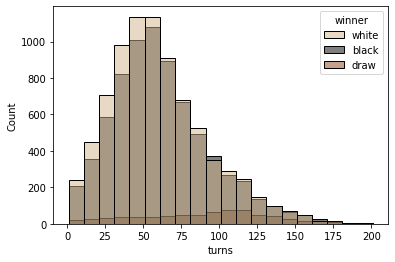

In [9]:
sns.histplot(data=df, x='turns', hue='winner', binwidth=10, hue_order=['white', 'black', 'draw'], palette=['tan', 'black', 'saddlebrown'])

`Stacked bar chart` лучше отобразит распределение продолжительности игр, однако он также скроет отношение количества побед обоих игроков.

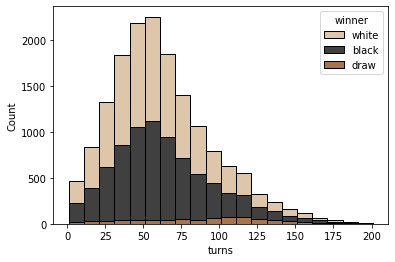

In [10]:
sns.histplot(data=df, x='turns', hue='winner', binwidth=10, hue_order=['white', 'black', 'draw'], palette=['tan', 'black', 'saddlebrown'], multiple='stack')

Пример некорректного графика: `dodge bar chart`. Он сочетает в себе лишь недостатки двух предыдущих графиков.

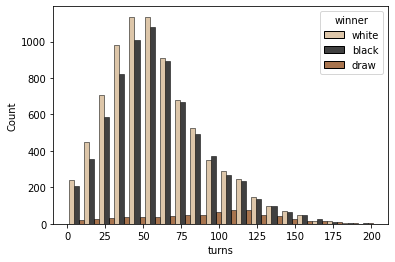

In [11]:
sns.histplot(data=df, x='turns', hue='winner', binwidth=10, hue_order=['white', 'black', 'draw'], palette=['tan', 'black', 'saddlebrown'], multiple='dodge')

## Шаг 2. Популярные дебюты

Для наглядного изображения десяти наиболее популярных шахматных дебютов применим горизонатальный `bar chart` с сортировкой.

In [12]:
grouped = df.groupby('opening_family', as_index=False)

In [35]:
agged = grouped.agg(
    game_count=pd.NamedAgg(column='opening_family', aggfunc='size'),
    mean_rating=pd.NamedAgg(column='game_rating', aggfunc='mean'),
    mean_white_rating=pd.NamedAgg(column='white_rating', aggfunc='mean'),
    mean_black_rating=pd.NamedAgg(column='black_rating', aggfunc='mean')
).sort_values('game_count', ascending=False).head(10)
popular_openings = agged.opening_family.values
agged

,opening_family,game_count,mean_rating,mean_white_rating,mean_black_rating
122,Sicilian Defense,2128,1679.710056,1663.550282,1696.369831
47,French Defense,1207,1616.848384,1621.549296,1612.670257
107,Queen's Pawn Game,1092,1582.846154,1580.336081,1585.874542
61,Italian Game,804,1589.197761,1593.424129,1585.481343
71,King's Pawn Game,744,1400.986559,1404.551075,1397.920699
115,Ruy Lopez,670,1625.168657,1631.368657,1619.455224
117,Scandinavian Defense,587,1529.231687,1532.117547,1526.860307
40,English Opening,562,1626.306050,1634.017794,1619.124555
94,Philidor Defense,560,1513.512500,1532.987500,1494.546429
21,Caro-Kann Defense,483,1642.633540,1642.772257,1642.989648


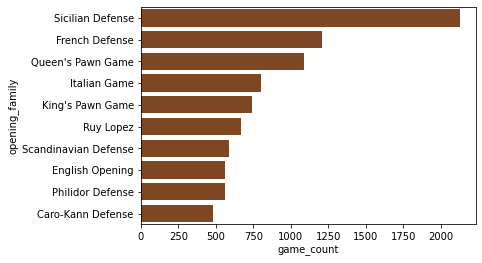

In [14]:
ax = sns.barplot(x=agged['game_count'], y=agged['opening_family'], color='saddlebrown')

Пример некорректного графика: `pie chart`...

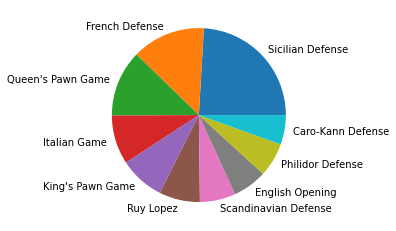

In [15]:
plt.pie(x=agged['game_count'], labels=agged['opening_family'])
plt.show()

## Шаг 3. Сравнение рейтингов популярных дебютов

Для сравнения средних рейтингов игр, в которых разыгрываются наиболее популярные дебюты, применим горизонтальный `lollipop chart`. Сортировка категорий *не изменяется* относительно шага 2. Маркеры на концах тонких полос `lollipop chart`-а позволяют более наглядно определить числовое значение для той или иной категории.

Text(0, 0.5, 'opening_family')

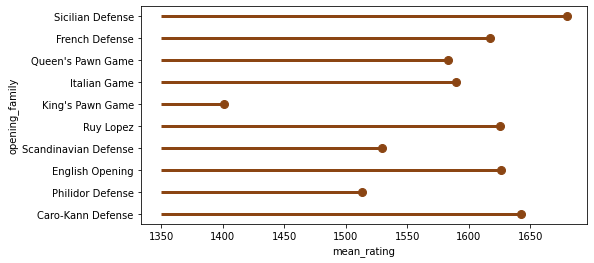

In [16]:
my_range = range(len(agged.index), 0, -1)

plt.figure(figsize=(8, 4))
plt.hlines(y=my_range, xmin=1350, xmax=agged['mean_rating'], color='saddlebrown', linewidth=3)
plt.plot(agged['mean_rating'], my_range, 'o', color='saddlebrown', markersize=8)
plt.yticks(my_range, agged['opening_family'])
plt.xlabel('mean_rating')
plt.ylabel('opening_family')

Пример крайне некорректного подхода: горизонтальный `bar chart`, сгруппированный по интервалам рейтинга.

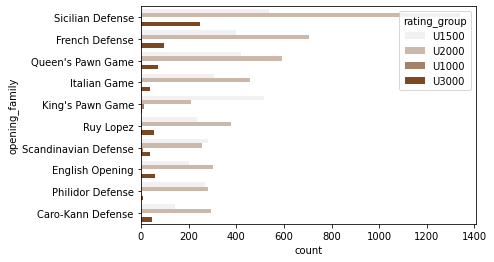

In [22]:
sns.countplot(y=df['opening_family'], orient='h', order=df['opening_family'].value_counts().iloc[:10].index, color='saddlebrown', hue=df['rating_group'])

## Шаг 4. Попарное сравнение рейтингов игроков популярных дебутов

Для попарного сравнения рейтингов наиболее подходящим оказывается "гибрид" `lollipop chart` и `dot plot`, так называемый `Cleveland chart`.

Text(0, 0.5, 'opening_family')

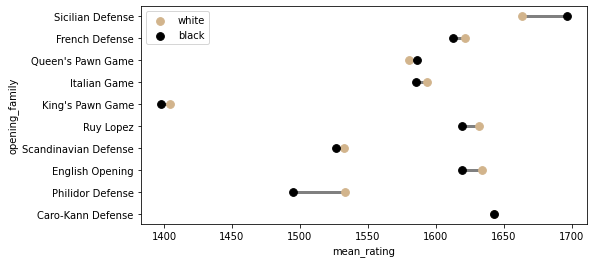

In [20]:
plt.figure(figsize=(8, 4))
plt.hlines(y=my_range,
           xmin=agged['mean_white_rating'],
           xmax=agged['mean_black_rating'],
           color='gray',
           linewidth=3,
           zorder=-1)
plt.scatter(agged['mean_white_rating'], 
            my_range,
            color='tan',
            label='white',
            s=60)
plt.scatter(agged['mean_black_rating'], 
            my_range,
            color='black',
            label='black',
            s=60)
plt.legend()
plt.yticks(my_range, agged['opening_family'])
plt.xlabel('mean_rating')
plt.ylabel('opening_family')

Пример некорректного графика: `parallel plot`. Хотя на этом графике можно изобразить отношение рейтингов игроков попарно, сравнить рейтинги различных дебютов между собой довольно сложно - десять линий сливаются друг с другом.

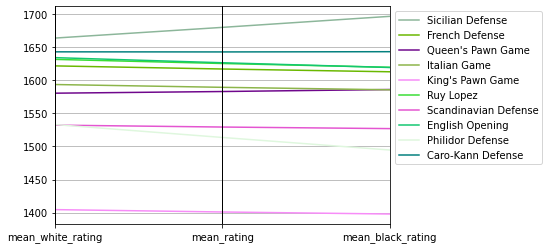

In [19]:
ax = pd.plotting.parallel_coordinates(agged, 'opening_family', cols=['mean_white_rating',  'mean_rating', 'mean_black_rating',])
ax.legend(bbox_to_anchor=(1, 1))

## Шаг 5 Статистика побед популярных дебютов в зависимости от продолжительности игры

In [24]:
def white_score(row):
  if row['winner'] == 'white':
    return 1
  elif row['winner'] == 'draw':
    return 0.5
  else:
    return 0

def black_score(row):
  return abs(row['wscore'] - 1)

In [25]:
df['wscore'] = df.apply(lambda row: white_score(row), axis=1)
df['bscore'] = df.apply(lambda row: black_score(row), axis=1)

In [73]:
df2 = df[df.opening_family.isin(popular_openings[:3])]

In [74]:
df2['turns_group'] = df2.turns.apply(lambda x: 10*((x + 5) // 10) + 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


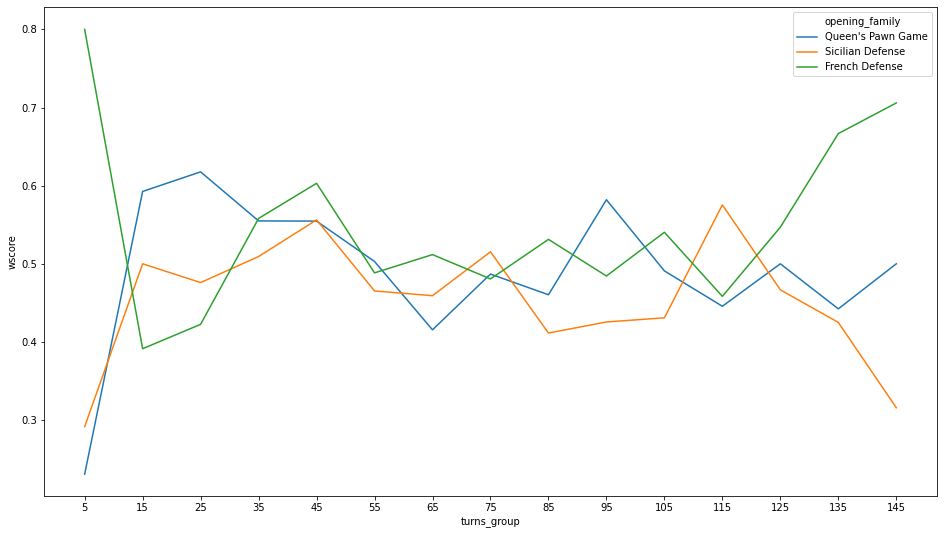

In [78]:
plt.figure(figsize=(16, 9))
plt.xticks(range(5, 155, 10))
sns.lineplot(x='turns_group', y='wscore', hue='opening_family', data=df2[df2.turns_group < 150], estimator='mean', ci=None)